#### 11/2/20

# Quick Start Guide 
-----------------
This notebook will show how to run a basic experiment using the `cfl` package. It will also explain the visual bars data and some background for CFL. 



Contents 
- Background (What is CFL?)
- Importing the `cfl` package 
- Loading Data 
- Saving Results 
- Training and Predicting with a CFL object 
- Visualizing the results  
- Beyond the Basics: Training and predicting just the conditional density or just with clustering 
- Beyond the Basics: Loading Saved Weights


## Background 

Causal Feature Learning (CFL) is an algorithm designed to construct macro-variables from low-level data in an unsupervised manner while accounting for the causal relationships between these macro-variables. Given low-level datasets, CFL aggregates them into two sets of macro-variables: a set of effects (e.g. emotional responses) and a set of potential causes (e.g. activity in regions of the brain).


CFL is designed to take two data sets as input: `X`, which contains all the potential 'causal' features in the data, and `Y`, which contains all the potential 'effect' features in the data. In other words, CFL pre-supposes that all potential causes to discover are in `X` (but not all the features in `X` need be causally important). 

CFL learns the conditional probability distribution $P(Y|X)$ (or some reasonable proxy for this distibution). It then clusters together Xs for which the equivalence relation $P(Y|X=x_1) = P(Y|X=x_2)$ is (approximately) true, followed by clustering Ys for which the relation $P(Y=y_1|X) = P(Y=y_2|X)$ approximately holds. Thus, CFL works in two steps: first, estimating the conditional density; and second, clustering.  

As stated above, CFL creates macrovariables from the low-level data. These macrovariables are two sets of partitions, one each for the cause and effect space. In our implementation below, these partitions are represented by labels on each of the samples used to train the two models, as well as the trained models themselves, which can then be used to classify further predictions as being members of specific macrovariables. 

In [29]:
#import standard pacakges 
import numpy as np #needed for reshaping arrays 
import matplotlib.pyplot as plt #for rendering plots

## Importing the `cfl` package 

Type `import cfl` in order to import the entire `cfl` package, or import the specific modules you intend to use. 

In [31]:
# importing cfl will import all of the sub-modules inside of cfl as well
import cfl

# you can also import specific files, functions, or classes
# into the local namespace 
from cfl.cfl_wrapper import make_CFL
from cfl.save.experiment_saver import ExperimentSaver
from cfl.dataset import Dataset

## Visual Bars Data

For this experiment, we will use the Visual Bars dataset (from Chalupka 2015). 

The causal dataset consists of a set of binary (black-and-white) images. These images each have a black background 
and contain white pixels of random noise. Each image may also contain either a white vertical and/or a horizontal bar. 

The effect dataset (aka the "Target") is, in this case, a single dimensional binary variable. In other words, there is only one variable in the target data set, and that variable can either be a "0" or a "1". 


The underlying causal structure used to generate the visual bars images includes two 'hidden variables', the contents of each image, and the target's value. The values of hidden variables are not observed directly in the data set, but they impact the values of variables that we do observe. 

The $H_{1}$ hidden variable being "on" deterministically causes a vertical bar to be present in the image. If the hidden variable is on, the vertical bar is present in the image. It also increases the probability that the target variable will be "on." The $H_{2}$ hidden variable causes a horizontal bar to be present in the image, but does not directly impact the value of the target. In an image, the presence of a horizontal bar increases the probability of the target being on, but the presence of a vertical bar does not directly increase the probability of the target being on. 

Below, these relationships are shown as a causal graph. The solid circles are the observed variables, the dotted lines are hidden (unobserved) variables, and the arrows denote a causal relationship from one variable to another. 

<img src="img/VisualBarsCausal.png" alt="causal graph for visual bars" height="200"/>


Wow! All that's a little confusing. What does it mean? 

Basically, this means that there is confounding in our set-up! You can see in the image above that $H_{1}$ has influence on both the images and the target directly. And confounding makes disentangling the causal relationships a little more complicated. 


So we want CFL to separate the images in our data set into 4 observational classes: one for each combination of values for H1 and H2. This will allow later experimenters to intervene across these boundaries and determine which of the differences in the images are causally important (the horizontal bars) versus predictive but not causal (the vertical bars)


The table below shows the 'ground truth' probability of the target value being on, given each possible state of the hidden variables. These values are used to generate the target values. We want to recover these probabilities as accurately as possible by the end of the density estimation step of CFL, and recover these four categories by the end of the clustering step.

<img src="img/VisualBarsProbs.png" alt="probability table for visual bars" height="150"/>


## Loading Visual Bars Data

In order to create a visual bars data set (ie a set of images and associated target values), we need to import the file `generate_visual_bars_data.py`. If you are trying to generate the visual bars data from somewhere outside the root directory of the reposity, add the visual_bars directory path to the PYTHONPATH (same as you did for the `cfl` package) for easy importing. 

In [33]:
#import the file to generate visual bars data 
import visual_bars.generate_visual_bars_data as vbd

# uncomment this line and use it instead if you have added visual_bars to the pythonpath
# import generate_visual_bars_data as vbd

In order to generate visual bars data, we set the number of images we want to generate (`n_samples`), the size of each image in pixels (`im_shape`), and the intensity of random noise in the image (`noise_lvl`). To have reproducible results, we also will set a random seed. 

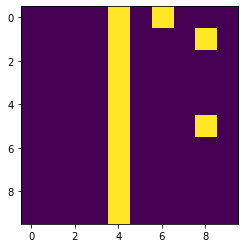

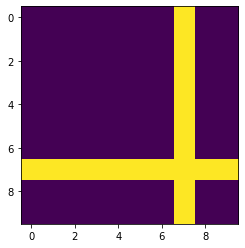

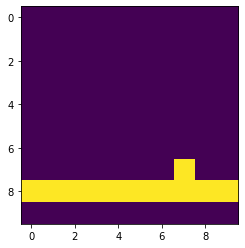

In [35]:
n_samples = 10000
im_shape = (10, 10)
noise_lvl= 0.03
set_seed = 180

# create visual bars data 
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=set_seed)

# visualize some example images 
vb_data.viewSingleImage()
vb_data.viewSingleImage()
vb_data.viewSingleImage()


We save the images to a variable `X` and the array of target behavior to a variable `Y`. Note that `X` and `Y` are aligned - they have the same number of observations, and the nth image in `X` corresponds to the nth target value in `Y`. 

In [37]:
# retrieve the images and the target 
X = vb_data.getImages()
Y = vb_data.getTarget()

# X and Y have the same number of rows  
print(X.shape)
print(Y.shape)
print(X.shape[0]==Y.shape[0])

(10000, 10, 10)
(10000,)
True


Finally, we reshape the `X` and `Y` into the right shapes to be passed through the conditional density estimation (CDE) step of CFL. Because the density estimation model we will use, `CondExp`, takes in 1-dimensional input, we need to flatten the 2D images into 1D before passing `X` in. NOTE: not all CDEs need the same input shape! Most take in 1D inputs, but a convolutional neural net (CNN), take in 2-D input. If we were using a CNN, we would not flatten `X`. 

We then expand `Y` because Tensorflow expects 2 dimensions, where the first dimension is samples and the second is features. So expanding to 2 dimensions is makes the shape (n_samples, 1)instead of (n_samples,).

In [39]:
#reformat x, y into the right shape for the neural net 
X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2])) 
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

(10000, 100)
(10000, 1)


## Key Points: Loading Data
- should have a data set X and a data set Y that are aligned (each row in X corresponds to the row with the same index in Y)
- For most instances of CFL, X and Y should be reshaped st that each one is a 2D array, where the first dimension is samples/observations and the second dimension is all the features 

## Saving Results 

We will now set up an experiment saver. This will save not only the results from each step of CFL, but also the parameters input to CFL. 

We will also pass the X and Y data into a Dataset object. Then, every time we pass that Dataset through any part of the CFL pipeline, the results will automatically be stored in a directory associated with that Dataset.  

In [41]:
# save experiment results from this CFL configuration across all datasets to 'results/visual_bars/experiment000x'
experiment_saver = ExperimentSaver('results/visual_bars')

# construct dataset. this will save all dataset-specific results to 'results/visual_bars/experiment000x/dataset0'
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver)

All results from this run will be saved to results/visual_bars/experiment0003


## Training and Predicting with a CFL object 

Now we're ready to go! 

First, CFL takes in several sets of parameters, each in dictionary form: 
- `data_info`  
- `CDE_params`   
- `cluster_params`   

For further details on the meaning of these parameters, consult the documentation for the clusterer and the CondExp base class. 

Note that not all of the CDE_params listed here need to be specified - if they are not specified, default values will be provided.  


In [43]:
# set all CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 32,
               'optimizer'   : 'adam',
               'n_epochs'    : 50,
               'verbose'     : 1,
               'opt_config'  : {'lr': 1e-4},
               'dense_units' : [50, 50, data_info['Y_dims'][1]],
               'activations' : ['relu', 'relu', 'sigmoid'],
               'dropouts'    : [0.2, 0.2, 0], 
               'show_plot'   : False }

    
# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 4 }

Then we make the cfl object with the `make_CFL` function! This function allows you to create both parts of the cfl model in one step. It takes in the parameter dictionaries, and strings specifying which type of CDE/ clusterer to use.  


In [45]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpMod', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) 

weights_path not specified in params, defaulting to None
loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExpMod


We train the CFL object on our data. 
The results are in the form `(x labels, y labels, train loss, test loss)`. 
The x labels and y labels are the macrovariable labels for each sample in the X and Y data set, respectively, 
and the trian and test losses are the losses from the density estimation step of training. 

Epoch 1/30
235/235 [==============================] - 0s 1ms/step - loss: 0.2364 - val_loss: 0.2227
Epoch 2/30
235/235 [==============================] - 0s 910us/step - loss: 0.2212 - val_loss: 0.2108
Epoch 3/30
235/235 [==============================] - 0s 828us/step - loss: 0.2108 - val_loss: 0.1990
Epoch 4/30
235/235 [==============================] - 0s 847us/step - loss: 0.1993 - val_loss: 0.1869
Epoch 5/30
235/235 [==============================] - 0s 881us/step - loss: 0.1881 - val_loss: 0.1744
Epoch 6/30
235/235 [==============================] - 0s 865us/step - loss: 0.1765 - val_loss: 0.1634
Epoch 7/30
235/235 [==============================] - 0s 820us/step - loss: 0.1689 - val_loss: 0.1550
Epoch 8/30
235/235 [==============================] - 0s 829us/step - loss: 0.1635 - val_loss: 0.1496
Epoch 9/30
235/235 [==============================] - 0s 824us/step - loss: 0.1583 - val_loss: 0.1458
Epoch 10/30
235/235 [==============================] - 0s 817us/step - loss: 0.1539 

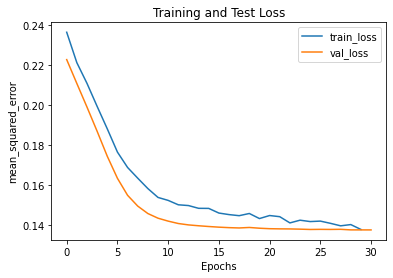

In [46]:
train_results = cfl_object.train(dataset0, standardize=False)

To predict on different data using the previously trained model, we just create a second data set with the same experiment_saver, and call the predict method on that new dataset: 

In [47]:
# make second dataset for prediction
# note: drawing from the same data as dataset0 for sake of demonstration (you would probably use different data)
dataset1 = Dataset(X[:100,:], Y[:100,:], dataset_label='dataset1', experiment_saver=experiment_saver) 

pyx = cfl_object.predict(dataset1)

100%|██████████| 100/100 [00:00<00:00, 10062.39it/s]


## Visualize Results 
We can view some images with their predicted label using the `viewImages` function. As we can see, the results are pretty inconsistent - multiple images that should be in the same class are part of different classes. This is in part because our sample size is not quite large enough for CFL to learn it very well. Try this experiment again with a larger sample size and see how the results change. You can also try with a different type of density estimator. 

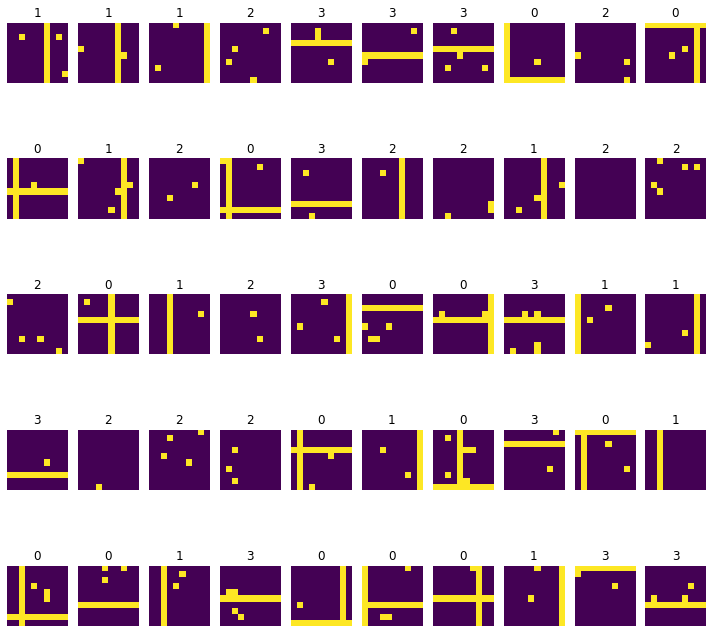

In [48]:
vb_data.viewImages(n_images=50, x_lbls=train_results[0][:50])

## Beyond the Basics: Training and predicting with just the conditional density or just with clustering 

In some cases, you may not want to perform both steps of CFL on your data, but rather just one of the steps. In that case, you need to make the CDE or clusterer object individually. 

The commands to train and predict with a component of the CFL follow the same pattern as with the full CFL. 

All results from this run will be saved to results/visual_bars/experiment0004
weights_path not specified in params, defaulting to None
loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExpMod
Epoch 1/30
235/235 [==============================] - 0s 1ms/step - loss: 0.2324 - val_loss: 0.2280
Epoch 2/30
235/235 [==============================] - 0s 812us/step - loss: 0.2175 - val_loss: 0.2167
Epoch 3/30
235/235 [==============================] - 0s 835us/step - loss: 0.2071 - val_loss: 0.2048
Epoch 4/30
235/235 [==============================] - 0s 871us/step - loss: 0.1959 - val_loss: 0.1914
Epoch 5/30
235/235 [==============================] - 0s 881us/step - loss: 0.1845 - val_loss: 0.1789
Epoch 6/30
235/235 [==============================] - 0s 839us/step - loss: 0.1739 - val_loss: 0.1686
Epoch 7/30
235/235 [==============================] - 0s 800us/step - loss: 0.1663 - val_loss: 0.1605
Epoch 8/30
235/235 [=========

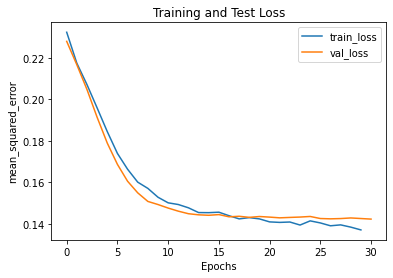

In [49]:
# save experiment results from this CFL configuration across all datasets to 'results/visual_bars/experiment000x'
# note: each new instantiation of ExperimentSaver will create a new experiment000x directory.
experiment_saver = ExperimentSaver('results/visual_bars')

# construct dataset. this will save all dataset-specific results to 'results/visual_bars/experiment000x/dataset0'
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver)

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 32,
               'optimizer'   : 'adam',
               'n_epochs'    : 50,
               'verbose'     : 1,
               'opt_config'  : {'lr': 1e-4},
               'dense_units' : [50, 50, data_info['Y_dims'][1]],
               'activations' : ['relu', 'relu', 'sigmoid'],
               'dropouts'    : [0.2, 0.2, 0], 
               'show_plot'   : False }

# construct a CDE object (no saver specified - results will not be saved)
CDE_object = cfl.density_estimation_methods.condExpMod.CondExpMod(data_info, CDE_params, experiment_saver=experiment_saver)

# training a CDE object is very straightforward! 
CDE_object.train(dataset0, standardize=False, best=True)

#predicting with it is also easy! 
pyx = CDE_object.predict(dataset0)


Average prediction for x-class 0: 0.12
Average prediction for x-class 1: 0.41
Average prediction for x-class 2: 0.76
Average prediction for x-class 3: 0.93


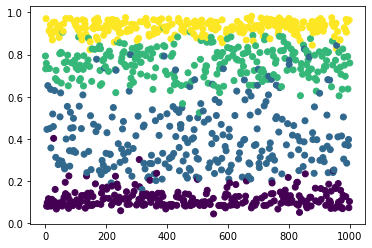

In [50]:
# create a scatter plot showing conditional expectation of the target, as predicted by the CDE, 
# colored by ground truth class  
truth = vb_data.getGroundTruth()
fig = plt.figure()
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)
plt.scatter(range(1000), pyx[plot_idx], c=truth[plot_idx])
fig.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i])))


However, what input and output each component needs depends on which step you're using: 

<img src="img/SampleCFLworkflow.png" alt="sample CFL workflow, showing inputs and outputs of each step" height="200"/>

So if you are working with just the clusterer, you need to input the conditional expectations, not the dataset! 

## Beyond the Basics: Loading Saved Results 

You can load a previously trained conditional density model by specifying a `weights_path` in the CDE_params dict. This can be helpful in the case where we want to tune the clusterer, but don't want to wait for the CDE to train every time we retrain the clusterer. 


Note: in the future, we will implement the ability to load parameters and the clusterer model from previous runs, but those methods doesn't exist at the moment. 

In [51]:
# making a new experiment to save to, because we're going to train a new clusterer!

# save experiment results from this CFL configuration across all datasets to 'results/visual_bars/experiment000x'
experiment_saver = ExperimentSaver('results/visual_bars')

# use the same dataset as before, to compare against original clusterer
# construct dataset. this will save all dataset-specific results to 'results/visual_bars/experiment000x/dataset0'
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver) # using new experiment saver

All results from this run will be saved to results/visual_bars/experiment0005


In [52]:
# set all CFL parameters

# dataset params should be same as before
# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# using same cde architecture as before
# conditional density estimator parameters
CDE_params = { 'batch_size'  : 32,
               'optimizer'   : 'adam',
               'n_epochs'    : 50,
               'verbose'     : 1,
               'opt_config'  : {'lr': 1e-4},
               'dense_units' : [50, 50, data_info['Y_dims'][1]],
               'activations' : ['relu', 'relu', 'sigmoid'],
               'dropouts'    : [0.2, 0.2, 0], 
               'show_plot'   : False,
               'weights_path': 'results/visual_bars/experiment0000/dataset0/checkpoints/best_weights' } # we want a pretrained cde to skip right to clustering

# we're going to try different cluster parameters!    
# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 6 }

In [53]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpMod', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) # new experiment saver

loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExpMod
Loading parameters from  results/visual_bars/experiment0000/dataset0/checkpoints/best_weights


In [54]:
# this should skip cde training and just go straight to clustering
train_results = cfl_object.train(dataset0, standardize=False)

No need to train, specified weights loaded already.
100%|██████████| 10000/10000 [00:02<00:00, 4377.31it/s]
